In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available


Import the survey and process the GRBs

In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [ ]:
ab.write_yaml("test_proc.yml")

In [2]:
ds = DataSet.from_yaml("test_proc.yml")

In [ ]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [6]:
ds.to_stan_dict()

OrderedDict([('N_intervals', 10),
             ('N_grbs', 2),
             ('max_n_echan', 140),
             ('max_n_chan', 128),
             ('object_idx', array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2])),
             ('grb_id', array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2])),
             ('N_dets', [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
             ('observed_counts',
              array([[[12., 11.,  7., ...,  0.,  0.,  5.],
                      [ 6.,  2.,  4., ...,  0.,  0., 10.],
                      [ 3.,  7.,  9., ...,  0.,  6.,  8.],
                      [ 6.,  5.,  5., ...,  0.,  2.,  5.]],
              
                     [[15., 13., 17., ...,  0.,  1.,  9.],
                      [ 5.,  6.,  2., ...,  0.,  2., 22.],
                      [ 3.,  4.,  6., ...,  0.,  6., 23.],
                      [ 6.,  4.,  3., ...,  0.,  9.,  8.]],
              
                     [[ 9., 14., 10., ...,  0.,  0., 10.],
                      [ 3.,  7.,  7., ...,  0.,  2., 25.],
                      [ 3

Make Stan model

In [10]:
m = get_model("cpl_simple_chunked_gc")

In [11]:
m.clean_model()

In [12]:
m.build_model()

18:09:45 - cmdstanpy - INFO - compiling stan file /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan to exe file /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
18:10:38 - cmdstanpy - INFO - compiled model executable: /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc
18:10:38 - cmdstanpy - WARNING - Stan compiler has produced 26 warnings:
18:10:38 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/chrobin/Documents/zusammen/zusammen/stan_models --o=/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.hpp /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan
Warning in '/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl.stan', line 35, column 41, included from
'/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 2, column 0: Declaration
    of arrays by placing bra

In [13]:
data = ds.to_stan_dict()

n_threads = 3
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    # inits= {'alpha':-1.},
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    show_progress=True,
)

18:10:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

22:09:31 - cmdstanpy - INFO - CmdStan done processing.


22:09:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate: error estimate of integral 8.39823e-06 exceeds the given relative tolerance times norm of integral (in '/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 150, column 4 to column 105)
	Exception: integrate: error estimate of integral 4.78798e-05 exceeds the given relative tolerance times norm of integral (in '/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 150, column 4 to column 105)
	Exception: integrate: error estimate of integral 5.06764e-06 exceeds the given relative tolerance times norm of integral (in '/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 150, column 4 to column 105)
	Exception: integrate: error estimate of integral 4.62026e-06 exceeds the given relative tolerance times norm of integral (in '/home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.

In [ ]:
m.model.sample?

Import Stan results into arviz

In [14]:
res = av.from_cmdstanpy(fit)

In [15]:
res.to_netcdf("test_inference_data_energy_flux_3.nc")

'test_inference_data_energy_flux_3.nc'

In [ ]:
res.sample_stats.treedepth.max()

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_sigma'}>,
        <AxesSubplot:title={'center':'log_energy_flux_sigma'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_raw'}>],
       [<AxesSubplot:title={'center':'log_Nrest'}>,
        <AxesSubplot:title={'center':'log_Nrest'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'int_scatter_sq'}>,
        <AxesSubplot:title={'center':'int_scatter_sq'}>],
       [<AxesSubplot:title={'center':'gamma_mu_meta'}>,
        <AxesSubplot:title={'center':'gamma_mu

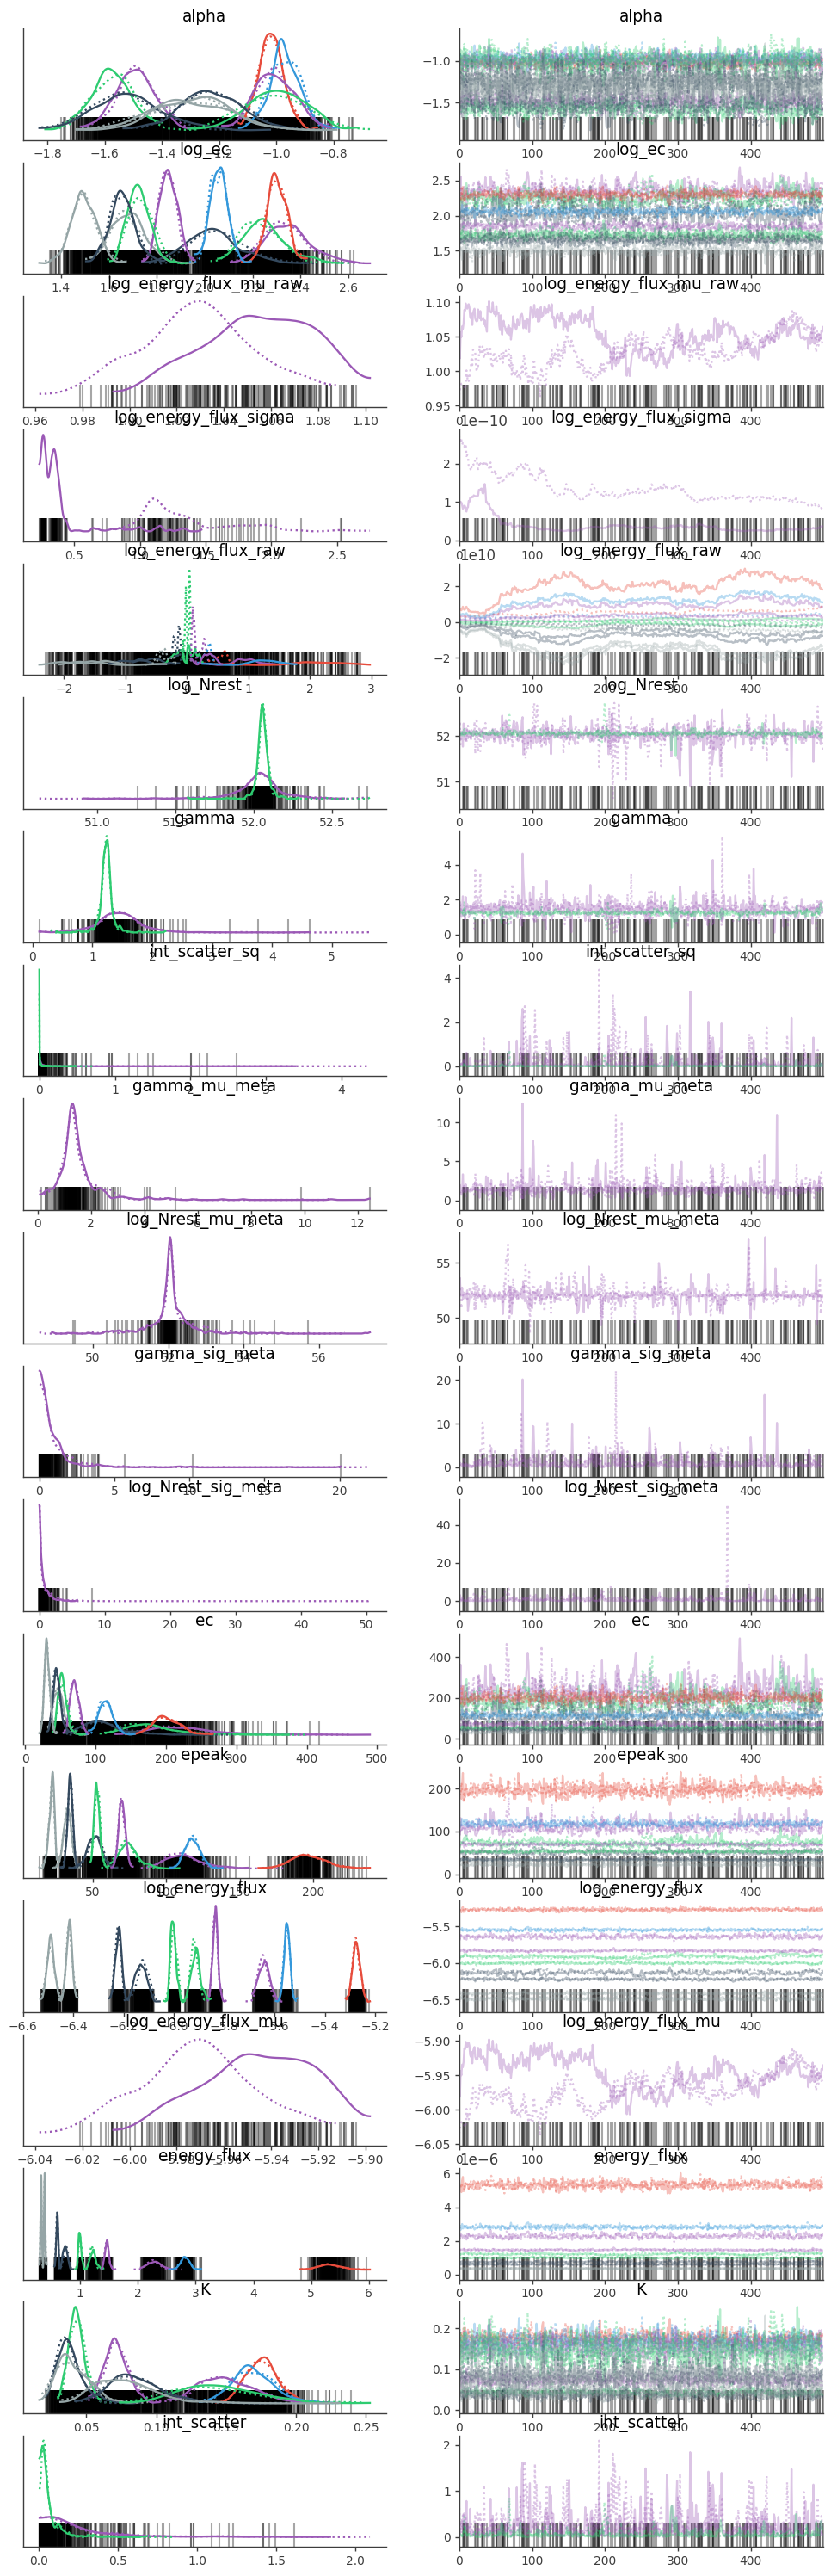

In [21]:
av.plot_trace(res)

In [ ]:
bc = Band_Calderone(opt=0, a =10, b=1e4)
bc.beta.fix = True

Load parameters  
    $\alpha$: parameter of CPL  
    $E_p = \log E_c$  
    $K$: normalization

In [16]:
id = 0

In [18]:
alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

epeak = res.posterior.epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [20]:
alpha

array([-1.55176, -1.5869 , -1.63816, -1.46988, -1.36773, -1.5595 ,
       -1.41903, -1.57255, -1.41462, -1.50708, -1.29397, -1.51422,
       -1.42261, -1.41656, -1.38246, -1.43305, -1.4899 , -1.49057,
       -1.52438, -1.458  , -1.52803, -1.42211, -1.4663 , -1.38149,
       -1.37312, -1.36297, -1.50238, -1.57904, -1.55254, -1.46746,
       -1.53295, -1.45599, -1.59654, -1.45655, -1.49284, -1.54009,
       -1.60127, -1.54731, -1.52143, -1.46076, -1.47755, -1.41847,
       -1.49834, -1.57998, -1.5644 , -1.57247, -1.44024, -1.5176 ,
       -1.50312, -1.54168, -1.54571, -1.47292, -1.46693, -1.45729,
       -1.48996, -1.38239, -1.47726, -1.50586, -1.61102, -1.29683,
       -1.48026, -1.40336, -1.42526, -1.45818, -1.53713, -1.37117,
       -1.4322 , -1.51319, -1.52168, -1.57343, -1.43344, -1.5149 ,
       -1.484  , -1.51286, -1.54212, -1.50637, -1.52718, -1.5405 ,
       -1.41428, -1.43211, -1.5257 , -1.43513, -1.41849, -1.54746,
       -1.54469, -1.53303, -1.47233, -1.52101, -1.47984, -1.55

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
fig, ax = plt.subplots()


ax.scatter(ep, alpha, alpha=0.1)


In [ ]:
fig, ax = plt.subplots()


ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl